In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
from diffusers import StableDiffusionPipeline, DDIMScheduler

# 1. Setup
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "CompVis/stable-diffusion-v1-4"

print(f"Loading model: {model_id}...")
# Use float32 to match other scripts in the repo
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float32)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.to(device)
pipe.set_progress_bar_config(disable=True)
print("Model loaded.")

Loading model: CompVis/stable-diffusion-v1-4...


/home/gpuadmin/cssin/cond_Jacobian/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Model loaded.


In [2]:
# 2. Load Prompts
def load_prompts(filepath):
    with open(filepath, 'r') as f:
        prompts = [line.strip() for line in f.readlines() if line.strip()]
    return prompts

mem_prompts_file = "prompts/sd1_mem.txt"
nmem_prompts_file = "prompts/sd1_nmem.txt"

mem_prompts = load_prompts(mem_prompts_file)
nmem_prompts = load_prompts(nmem_prompts_file)

print(f"Loaded {len(mem_prompts)} memorized prompts.")
print(f"Loaded {len(nmem_prompts)} non-memorized prompts.")

Loaded 500 memorized prompts.
Loaded 500 non-memorized prompts.


Generating 5 images for Memorized prompts...
Generating 5 images for Non-Memorized prompts...


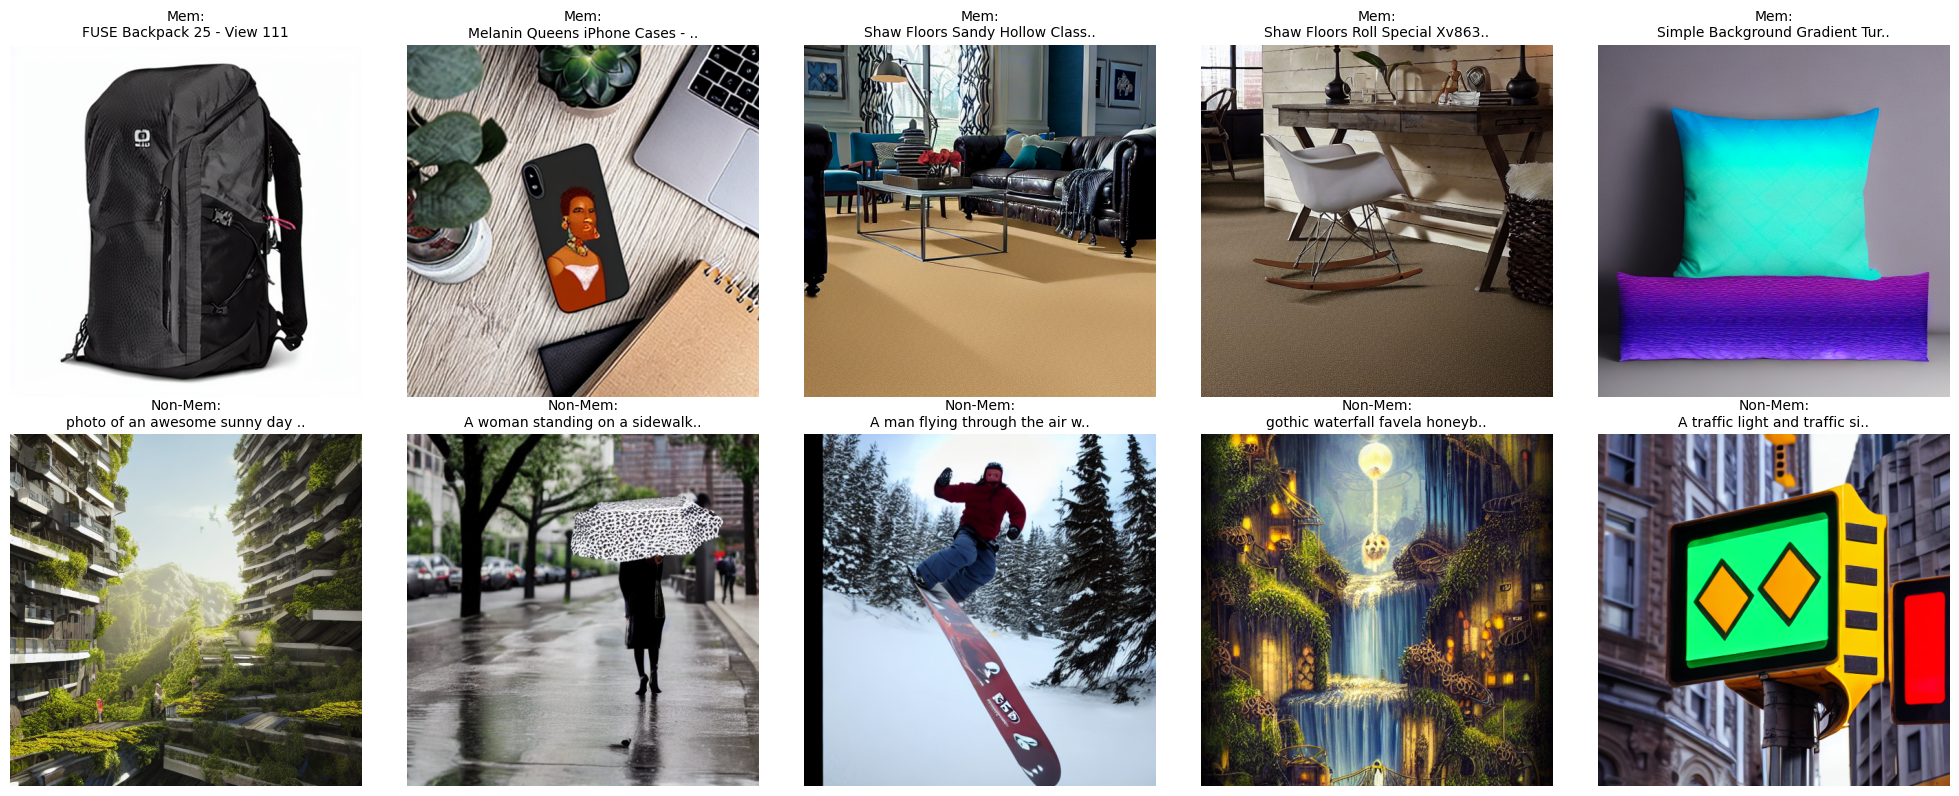

In [16]:
# 3. Select n random prompts and Generate
n = 5  # Number of prompts to select

# Randomly sample Prompts
selected_mem = random.sample(mem_prompts, n)
selected_nmem = random.sample(nmem_prompts, n)

def generate_images(prompts, pipeline, seed=42):
    images = []
    # Use a generator for reproducibility
    generator = torch.Generator(device=device).manual_seed(seed)
    for p in prompts:
        # The user wants to see what happens inside this pipeline call.
        # See the next cell for a breakdown.
        img = pipeline(p, num_inference_steps=50, generator=generator).images[0]
        images.append(img)
    return images

print(f"Generating {n} images for Memorized prompts...")
mem_images = generate_images(selected_mem, pipe)

print(f"Generating {n} images for Non-Memorized prompts...")
nmem_images = generate_images(selected_nmem, pipe)

# 4. Visualize Results
fig, axes = plt.subplots(2, n, figsize=(4*n, 8))

# Plot Memorized
for i, (img, prompt) in enumerate(zip(mem_images, selected_mem)):
    ax = axes[0, i] if n > 1 else axes[0]
    ax.imshow(img)
    ax.axis("off")
    short_prompt = (prompt[:30] + '..') if len(prompt) > 30 else prompt
    ax.set_title(f"Mem:\n{short_prompt}", fontsize=10)

# Plot Non-Memorized
for i, (img, prompt) in enumerate(zip(nmem_images, selected_nmem)):
    ax = axes[1, i] if n > 1 else axes[1]
    ax.imshow(img)
    ax.axis("off")
    short_prompt = (prompt[:30] + '..') if len(prompt) > 30 else prompt
    ax.set_title(f"Non-Mem:\n{short_prompt}", fontsize=10)

plt.tight_layout()
plt.show()

In [3]:
from tqdm.auto import tqdm

def find_robust_point_batch(unet, 
                            prompt_embeds, 
                            latents, 
                            t, 
                            epsilon=1e-2, 
                            step_size=1e-3, 
                            power_iteration_steps=50,
                            eps_pi = 1e-4,
                            method='power_iteration'):
    """
    x_origin: [1, 77, 768] 형태의 입력 텐서
    epsilon: x의 의미가 변하지 않는다고 허용하는 최대 거리 (L2 norm)
    method: 'power_iteration' (근사) 또는 'numerical' (Finite Difference로 J 직접 계산)
            power_iteration을 사용할 경우 power_iteration_steps 만큼 반복하여 v_optimal을 추정합니다.
    """
    
    # 1. 입력 텐서 복제 및 Gradient 설정
    x = prompt_embeds.clone().detach().requires_grad_(True)
    
    v_optimal = None
    
    if method == 'power_iteration':
        # 2-A. Power Iteration을 통해 Jc의 가장 큰 Singular Vector (v_optimal) 찾기
        
        # 1-1. 랜덤 벡터 v 초기화
        v = torch.randn_like(x)
        v = v / (torch.norm(v) + 1e-8)
        
        # 1-2. Power Iteration 반복
        for _ in tqdm(range(power_iteration_steps), desc="Power Iteration"):
            # (A) J*v 계산: Finite Difference 이용
            with torch.no_grad():
                # 매번 현재의 v 방향으로 섭동을 주어 Output 공간의 변화량 u를 추정
                output_curr = unet(latents, t, encoder_hidden_states=x).sample
                output_pert = unet(latents, t, encoder_hidden_states=x + eps_pi * v).sample
                u_approx = (output_pert - output_curr) / eps_pi 
            
            # (B) J^T * u 계산: Vector-Jacobian Product (VJP)
            # Graph를 생성하여 Gradient를 계산해야 하므로 forward 한 번 더 수행
            # x는 requires_grad=True 상태
            output = unet(latents, t, encoder_hidden_states=x).sample 
            
            # x에 대한 Gradient = J^T * u_approx
            # retain_graph=False로 해도 루프 내에서 다시 forward하므로 문제 없음
            v_grad = torch.autograd.grad(output, x, grad_outputs=u_approx, create_graph=False)[0]
            
            # 정규화하여 다음 Step의 v로 사용
            current_norm = torch.norm(v_grad)
            if current_norm > 1e-8:
                v = v_grad / current_norm
            else:
                # Gradient가 0이면 랜덤 재초기화 등을 고려할 수 있으나 여기선 유지
                v = v_grad
            
            # v는 Gradient Tracking 불필요
            v = v.detach()
            
        v_optimal = v
        
    elif method == 'numerical':
        # 2-B. Numerical Jacobian 계산 (Finite Difference) 및 SVD
        print("Calculating Numerical Jacobian... This may take a long time.")
        
        # 입력 Flatten
        input_dim = x.numel() # 77 * 768
        x_flat_shape = x.shape
        
        # 출력 차원 확인을 위한 Dummy Pass
        with torch.no_grad():
            output_dummy = unet(latents, t, encoder_hidden_states=x).sample
            output_dim = output_dummy.numel()
            
        # Jacobian Matrix 초기화 [Output_Dim, Input_Dim]
        J = torch.zeros((output_dim, input_dim), device=x.device)
        
        with torch.no_grad():
            base_output = output_dummy.view(-1)
            
            # 입력 차원 전체 순회
            pbar = tqdm(range(input_dim), desc="Computing Numerical Jacobian")
            for i in pbar:
                # x[i]에만 섭동을 줌
                # 효율성을 위해 x를 매번 복사지 않고, 해당 인덱스만 조작 후 복구하는 방식 사용
                orig_val = x.view(-1)[i].item()
                
                # 섭동 적용
                x.view(-1)[i] += eps_pi
                
                # Forward
                output_try = unet(latents, t, encoder_hidden_states=x).sample
                output_try_flat = output_try.view(-1)
                
                # Finite Difference
                J[:, i] = (output_try_flat - base_output) / eps_pi
                
                # 복구
                x.view(-1)[i] = orig_val
        
        print("Performing SVD on Jacobian...")
        try:
            # J = U S V^T
            # Vh: V^T matrix. Row 0 corresponds to the largest singular value.
            # Vh shape: [min(M, N), N] or [N, N] depending on full_matrices
            U, S, Vh = torch.linalg.svd(J, full_matrices=False)
            
            # Vh[0] is the right singular vector for the largest singular value
            v_optimal_flat = Vh[0]
            v_optimal = v_optimal_flat.view(x_flat_shape)
            print(f"Max Singular Value: {S[0].item()}")
            
        except Exception as e:
            print(f"SVD Failed: {e}. Using Random Vector.")
            v_optimal = torch.randn_like(x)
            v_optimal = v_optimal / (torch.norm(v_optimal) + 1e-8)
            
        v_optimal = v_optimal.detach()

    # 3. condition embedding을 조금 움직임 (move slightly)
    # initial step에서의 Jc 방향으로 이동
    x.data = x.data + step_size * v_optimal

    # 4. Projection (의미 보존)
    #with torch.no_grad():
    #    diff = x - prompt_embeds
    #    norm = torch.norm(diff)
    #    if norm > epsilon:
    #        x.data = prompt_embeds + diff * (epsilon / norm)

    print(f'변화량 : {torch.norm(x - prompt_embeds)}')
    print(f'상대적인 변화율 : {torch.norm(x - prompt_embeds) / torch.norm(prompt_embeds) * 100}%')
            
    return x.detach().requires_grad_(False)

In [4]:
def compute_jacobian_norm_batched(unet, latents, t, prompt_embeds, num_projections=1):
    """
    Batched Hutchinson estimator for ||J||_F.
    Returns a tensor of shape (batch_size,) containing the Jacobian norm for each sample.
    """
    prompt_embeds = prompt_embeds.detach()
    latents = latents.detach()
    
    batch_size = latents.shape[0]
    
    with torch.enable_grad():
        prompt_embeds.requires_grad_(True)
        # Forward pass
        noise_pred = unet(latents, t, encoder_hidden_states=prompt_embeds).sample
        
        sq_norm_sum = torch.zeros(batch_size, device=latents.device)
        
        for k in range(num_projections):
            # Random probe v
            v = torch.randn_like(noise_pred)
            
            v_dot_eps_sum = torch.sum(noise_pred * v)
            
            retain = (k < num_projections - 1)
            grads = torch.autograd.grad(v_dot_eps_sum, prompt_embeds, retain_graph=retain, create_graph=False)[0]
            
            # Squared norm per sample
            grads_sq_flat = grads.view(batch_size, -1).pow(2)
            sample_sq_norms = grads_sq_flat.sum(dim=1) # [B]
            
            sq_norm_sum += sample_sq_norms.detach()
            
        est_frob_sq = sq_norm_sum / max(1, float(num_projections))
        return est_frob_sq.sqrt() # [B]

In [6]:
n = 5
selected_mem = random.sample(mem_prompts, n)
selected_nmem = random.sample(nmem_prompts, n)
target_prompt = selected_mem[0]  # Pick the first memorized prompt for inspection

Inspecting generation for: Aero 53-204720 53 Series 15x10 Wheel, BLock, 5 on 4-3/4 BP, 2 Inch BS


Power Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

변화량 : 3.0
상대적인 변화율 : 1.2168848514556885%
Starting denoising loop...


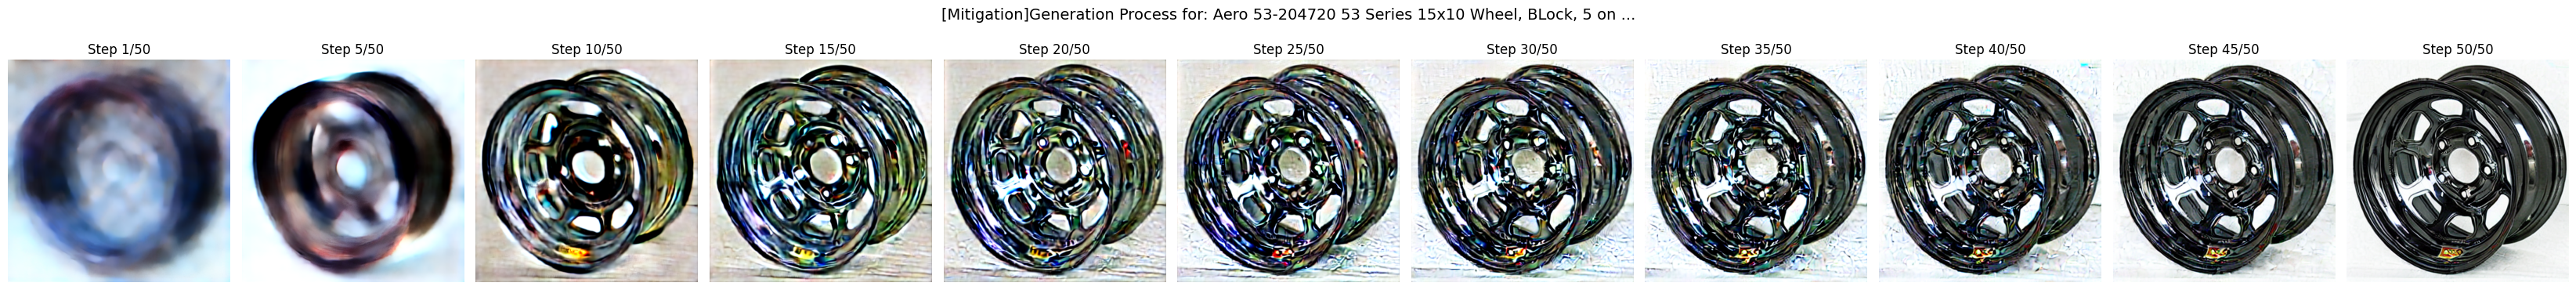

In [10]:
# 5. Step-by-Step Pipeline Inspection
# This cell manually deconstructs the pipeline generation process to visualize intermediate steps.
target_prompt = selected_mem[2]  # Pick the first memorized prompt for inspection

print(f"Inspecting generation for: {target_prompt}")

# (A) Encode Prompt
# Get text embeddings
text_inputs = pipe.tokenizer(
    [target_prompt], padding="max_length", max_length=pipe.tokenizer.model_max_length, truncation=True, return_tensors="pt"
)
with torch.no_grad():
    cond_embeddings = pipe.text_encoder(text_inputs.input_ids.to(device))[0]

# Get unconditional embeddings (for Classifier-Free Guidance)
max_length = text_inputs.input_ids.shape[-1]
uncond_input = pipe.tokenizer(
    [""], padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = pipe.text_encoder(uncond_input.input_ids.to(device))[0]

text_embeddings_origin = torch.cat([uncond_embeddings, cond_embeddings])

# (B) Initialize Latents (Noise)
generator = torch.Generator(device=device).manual_seed(42)
latents = torch.randn(
    (1, pipe.unet.config.in_channels, 64, 64),
    generator=generator,
    device=device,
    dtype=pipe.unet.dtype
)

# (C) Set Scheduler
pipe.scheduler.set_timesteps(50)
timesteps = pipe.scheduler.timesteps

initial_timestep = timesteps[0]

latent_for_PGD = pipe.scheduler.scale_model_input(latents, initial_timestep)

PGD_prompts_embeddings = find_robust_point_batch(pipe.unet,  
                                                prompt_embeds = cond_embeddings,
                                                latents = latent_for_PGD, 
                                                t = initial_timestep,
                                                epsilon=1e-2, 
                                                power_iteration_steps=1,
                                                step_size=-3.,
                                                eps_pi = 1e-4,
                                                method='power_iteration')

text_embeddings = torch.cat([uncond_embeddings, PGD_prompts_embeddings])

# (D) Denoising Loop
intermediates = []
print("Starting denoising loop...")

for i, t in enumerate(timesteps):
    # 1. Expand latents for guidance (double the batch for uncond + cond)
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # 2. Predict Noise Residual
    with torch.no_grad():
        noise_pred = pipe.unet(
            latent_model_input, t, encoder_hidden_states=text_embeddings
        ).sample

    # 3. Perform Guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    guidance_scale = 7.5
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # 4. Compute Previous Noisy Sample x_t-1
    # 4. Compute Previous Noisy Sample x_t-1 and Predicted Original Sample x_0
    step_output = pipe.scheduler.step(noise_pred, t, latents)
    latents = step_output.prev_sample
    pred_original_sample = step_output.pred_original_sample

    # 5. Capture Intermediate Result (Decode to Image)
    # Decoding is expensive, so we do it every 10 steps or at specific checkpoints
    if i == 0 or (i + 1) % 5 == 0:
        with torch.no_grad():
            # Scale latents before decoding (SD v1.4 specific constant)
            latents_to_viz = 1 / 0.18215 * pred_original_sample
            image = pipe.vae.decode(latents_to_viz).sample
            # Rescale to [0, 1]
            image = (image / 2 + 0.5).clamp(0, 1)
            image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
            intermediates.append((i+1, image))

# 6. Visualize Steps
num_viz = len(intermediates)
fig, axes = plt.subplots(1, num_viz, figsize=(3*num_viz, 4))
plt.suptitle(f"[Mitigation]Generation Process for: {target_prompt[:50]}...", fontsize=14)

for idx, (step, img) in enumerate(intermediates):
    if num_viz > 1:
        ax = axes[idx]
    else:
        ax = axes
    ax.imshow(img)
    ax.set_title(f"Step {step}/50")
    ax.axis("off")

plt.tight_layout()
plt.show()

Starting denoising loop...


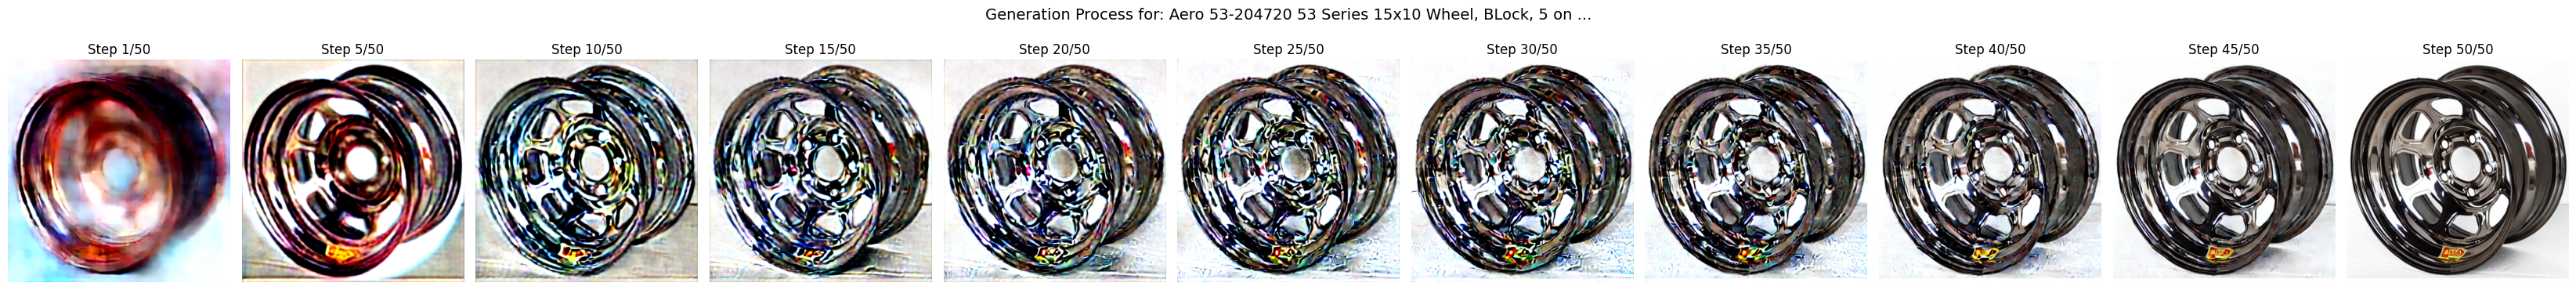

In [8]:
generator = torch.Generator(device=device).manual_seed(42)
latents = torch.randn(
    (1, pipe.unet.config.in_channels, 64, 64),
    generator=generator,
    device=device,
    dtype=pipe.unet.dtype
)

# (C) Set Scheduler
pipe.scheduler.set_timesteps(50)
timesteps = pipe.scheduler.timesteps

# (D) Denoising Loop
intermediates = []
print("Starting denoising loop...")

for i, t in enumerate(timesteps):
    # 1. Expand latents for guidance (double the batch for uncond + cond)
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # 2. Predict Noise Residual
    with torch.no_grad():
        noise_pred = pipe.unet(
            latent_model_input, t, encoder_hidden_states=text_embeddings_origin
        ).sample

    # 3. Perform Guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    guidance_scale = 7.5
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # 4. Compute Previous Noisy Sample x_t-1
    step_output = pipe.scheduler.step(noise_pred, t, latents)
    latents = step_output.prev_sample
    pred_original_sample = step_output.pred_original_sample


    # 5. Capture Intermediate Result (Decode to Image)
    # Decoding is expensive, so we do it every 10 steps or at specific checkpoints
    if i == 0 or (i + 1) % 5 == 0:
        with torch.no_grad():
            # Scale latents before decoding (SD v1.4 specific constant)
            latents_to_viz = 1 / 0.18215 * pred_original_sample
            image = pipe.vae.decode(latents_to_viz).sample
            # Rescale to [0, 1]
            image = (image / 2 + 0.5).clamp(0, 1)
            image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
            intermediates.append((i+1, image))

# 6. Visualize Steps
num_viz = len(intermediates)
fig, axes = plt.subplots(1, num_viz, figsize=(3*num_viz, 4))
plt.suptitle(f"Generation Process for: {target_prompt[:50]}...", fontsize=14)

for idx, (step, img) in enumerate(intermediates):
    if num_viz > 1:
        ax = axes[idx]
    else:
        ax = axes
    ax.imshow(img)
    ax.set_title(f"Step {step}/50")
    ax.axis("off")

plt.tight_layout()
plt.show()